We will use the [Fuel](https://github.com/mila-udem/fuel) library to access datasets. Fuel is designed to provide easy iteration over large datasets, however in this assignment we will only use its ability to download and convert some standard datasets for us.

We will use the following datasets:
1. IRIS https://archive.ics.uci.edu/ml/datasets/Iris available as `fuel.datasets.iris.Iris`
2. MNIST http://yann.lecun.com/exdb/mnist/ available as `fuel.datasets.mnist.MNIST`
3. CIFAR10 http://www.cs.toronto.edu/~kriz/cifar.html available as `fuel.datasets.cifar10.CIFAR10`

On lab computers the datasets have already been downloaded for you into the `/pio/data/data/fuel` directory. Make sure to add it to the `FUEL_DATA_PATH` environment variable!

If you are working from your computer, you can either use the Fuel downloader and converter utulities (http://fuel.readthedocs.org/en/latest/built_in_datasets.html) or download the HDF5 datasets:

1. [Iris](https://drive.google.com/uc?export=download&id=0B5j9vIO_Njwcb2ItV2ZLakR6MEk)
2. [MNIST](https://drive.google.com/uc?export=download&id=0B5j9vIO_NjwcNnYzVTNIVGxaSEk)
3. [CIFAR10](https://drive.google.com/uc?export=download&id=0B5j9vIO_NjwcOEdlU2RtNkc2bW8)


In [123]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Problem 1

We have 50000 training, 10000 validation, and 10000 test examples
The examples are pairs of (u'features', u'targets'):
The source #0 named "features" is a 4d array with axis: (u'batch', u'channel', u'height', u'width')
The source #1 named "targets" is a 2d array with axis: (u'batch', u'index')


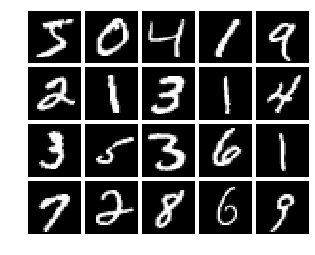

In [5]:
# loading MNIST data

from fuel.datasets.mnist import MNIST
from common.plotting import plot_mat


mnist_train = MNIST(("train",), subset=slice(None,50000))
mnist_validation = MNIST(("train",), subset=slice(50000, None))
mnist_test = MNIST(("test",))

print "We have %d training, %d validation, and %d test examples" % (
    mnist_train.num_examples, mnist_validation.num_examples, mnist_test.num_examples)
print "The examples are pairs of %s:" % (mnist_train.sources,)
for i, source in enumerate(mnist_train.sources):
    labels = mnist_train.axis_labels[source]
    print 'The source #%d named "%s" is a %dd array with axis: %s' % (
        i, source, len(labels), labels)

#Note that for larger datasets that are loaded into mameory the data_sources field may not exist!
plot_mat(mnist_train.data_sources[0][:20], cmap='gray')

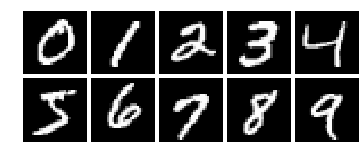

In [6]:
#
# plot an example of each class on MNIST and on CIFAR
#

#MNIST
class_map = [i[0] for i in mnist_train.data_sources[1]]
classes = [class_map.index(i) for i in set(class_map)]
plot_mat(mnist_train.data_sources[0][classes], cmap = 'gray')

In [7]:
#CIFAR

from fuel.datasets.cifar10 import CIFAR10

# CIFAR10 has same amount of images as mnist
cifar10_train = CIFAR10(("train",), subset=slice(None, 40000))
cifar10_validation = CIFAR10(("train",), subset=slice(40000, None))
cifar10_test = CIFAR10(("test",))

print "We have %d training, %d validation, and %d test examples" % (
    cifar10_train.num_examples, cifar10_validation.num_examples, cifar10_test.num_examples)
print "The examples are pairs of %s:" % (cifar10_train.sources,)
for i, source in enumerate(cifar10_train.sources):
    labels = cifar10_train.axis_labels[source]
    print 'The source #%d named "%s" is a %dd array with axis: %s' % (
        i, source, len(labels), labels)


We have 40000 training, 10000 validation, and 10000 test examples
The examples are pairs of (u'features', u'targets'):
The source #0 named "features" is a 4d array with axis: (u'batch', u'channel', u'height', u'width')
The source #1 named "targets" is a 2d array with axis: (u'batch', u'index')


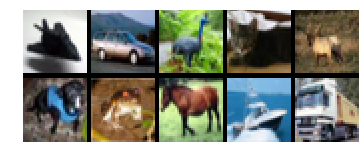

In [8]:
class_map = [i[0] for i in cifar10_train.data_sources[1]]
classes = [class_map.index(i) for i in set(class_map)]
plot_mat(cifar10_train.data_sources[0][classes], cmap = 'gray')

In [9]:
#Extract the data matrices

mnist_train_X = (mnist_train.data_sources[0].reshape(mnist_train.num_examples, -1) / 255.0).astype(np.single)
mnist_train_Y = mnist_train.data_sources[1].ravel()

mnist_valid_X = (mnist_validation.data_sources[0].reshape(mnist_validation.num_examples, -1) / 255.0).astype(np.single)
mnist_valid_Y = mnist_validation.data_sources[1].ravel()

In [461]:
from scipy.stats import mode
from scipy.spatial.distance import cdist

def KNN(train_X, train_Y, test_X, test_Y, ks, batch_size=200, callback=(lambda x: x)):
    """
    Compute error rate for various 
    """
    max_k = max(ks)
    errs = np.zeros((len(ks),))
    fold = ones((1,1,train_X.shape[1]))
    for i in xrange(0,test_Y.shape[0], batch_size):
        batch_X = test_X[i:i + batch_size]
        batch_Y = test_Y[i:i + batch_size]
        print "%d:%d D" %(i,i+batch_size), 
        
        #
        # an efficient distance matrix computation 
        # NOTE: numpy magic to fit matrix into given code
        train = train_X
        # test = batch_X[:,None]
        # diff = (train-test)**2
        # diff = (train-batch_X[:, None])**2
        # dists = cdist(train, batch_X, 'euclidean')
        dists = [[np.sqrt(np.sum((x-y)**2)) for y in batch_X] for x in train]
         
        print "S",
        #ind = np.argpartition(dists, max_k, axis = 0)
        #closest = ind[np.argsort(dists[ind], 0)]
        #print closest.shape
        closest = np.argsort(dists,0)
        #print closest[:max_k, :], closest_v2[:max_k, :]

        print "E",
        targets = train_Y[closest]
        
        for ki,k in enumerate(ks):
            predictions, unused_counts = mode(targets[:k,:], axis=0)
            predictions = predictions.ravel()
            #
            # error count computation
            #
            tmp_errs = minimum(abs(predictions - batch_Y), ones((len(batch_Y)),)) 
            errs[ki] += sum(tmp_errs)
            callback(tmp_errs)
            #print ki, predictions.shape, batch_Y.shape, errs[ki]
            
        print " | ",
        
    print "<done>"
    errs /= test_Y.shape
    return np.vstack((ks, errs))

In [462]:
X = arange(0, 100).reshape(20,5)
Y = logspace(0., 10., 10).reshape(2,5)
# cdist(X,Y), [[np.sqrt(np.sum((x-y)**2)) for y in Y] for x in X]

In [456]:
small_length = 5000
small_train_X = (mnist_train.data_sources[0][:small_length].reshape(small_length, -1) / 255.0).astype(np.single)

valid_length = 10000
small_valid_X = (mnist_validation.data_sources[0][:valid_length].reshape(valid_length, -1) / 255.0).astype(np.single)
errs = KNN(small_train_X, mnist_train_Y[:small_length], small_valid_X, mnist_valid_Y[:small_length], [1,3,5,7,9], 400)
plot(errs[0, :], errs[1, :])

0:400 D S E  |  400:800 D S E  |  800:1200 D S E  |  1200:1600 D S E  |  1600:2000 D S E  |  2000:2400 D S E  |  2400:2800 D S E  |  2800:3200 D S E  |  3200:3600 D S E  |  3600:4000 D S E  |  4000:4400 D S E  |  4400:4800 D S E  |  4800:5200 D S E

ValueError: operands could not be broadcast together with shapes (400,) (200,) 

 0:1000 D S E | 1000:2000 D S E | 2000:3000 D S E | 3000:4000 D S E | 4000:5000 D S E | 5000:6000 D S E | 6000:7000 D S E | 7000:8000 D S E | 8000:9000 D S E | 9000:10000 D S E |

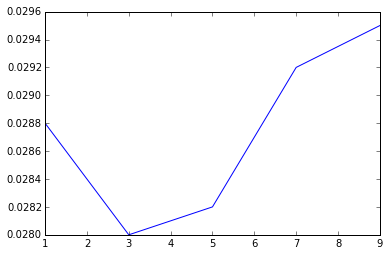

In [14]:
# Now find the best k on the validation set

mnist_validation_errs = KNN(mnist_train_X, mnist_train_Y, mnist_valid_X, mnist_valid_Y, [1,3,5,7,9], 1000)
plot(mnist_validation_errs[0,:], mnist_validation_errs[1,:])


In [ ]:
# Now use the best k to compute the test error

best_K =  3

mnist_full_train = MNIST(("train",), )

mnist_full_train_X = (mnist_full_train.data_sources[0].reshape(mnist_full_train.num_examples, -1) / 255.0).astype(np.single)
mnist_full_train_Y = mnist_full_train.data_sources[1].ravel()

mnist_test_X = (mnist_test.data_sources[0].reshape(mnist_test.num_examples, -1) / 255.0).astype(np.single)
mnist_test_Y = mnist_test.data_sources[1].ravel()

t = []
mnist_test_errs = KNN(mnist_full_train_X, mnist_full_train_Y, mnist_test_X, mnist_test_Y, [best_K], 100, callback = (lambda x: t.append(x)))
print "\nWhen k=%d the test error rate is %.1f%%" % (mnist_test_errs[0,0], mnist_test_errs[1,0]*100.0)

In [101]:
#
# Now repeat the k-NN training for CIFAR10
#
#Extract the data matrices

cifar10_train_X = (cifar10_train.data_sources[0].reshape(cifar10_train.num_examples, -1) / 255.0).astype(np.single)
cifar10_train_Y = cifar10_train.data_sources[1].ravel()

cifar10_valid_X = (cifar10_validation.data_sources[0].reshape(cifar10_validation.num_examples, -1) / 255.0).astype(np.single)
cifar10_valid_Y = cifar10_validation.data_sources[1].ravel()

0:1000 D S E |

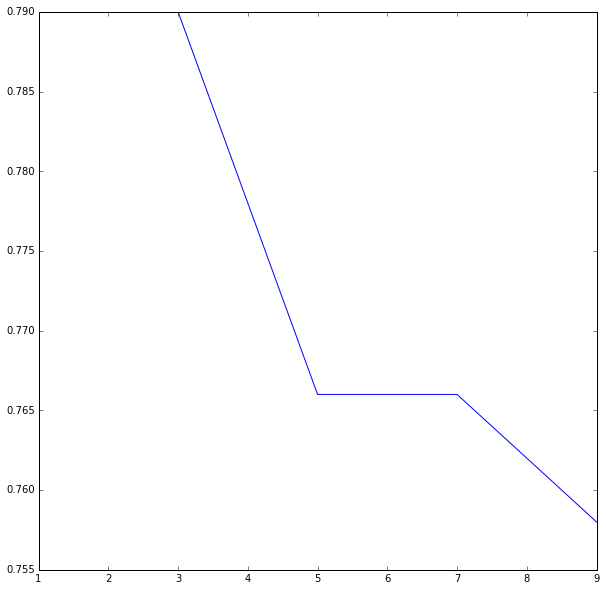

In [102]:
small_length = 1000
small_train_X = (cifar10_train.data_sources[0][:small_length].reshape(small_length, -1) / 255.0).astype(np.single)

valid_length = 10000
small_valid_X = (cifar10_validation.data_sources[0][:valid_length].reshape(valid_length, -1) / 255.0).astype(np.single)
errs = KNN(small_train_X, cifar10_train_Y[:small_length], small_valid_X, cifar10_valid_Y[:small_length], [1,3,5,7,9], 1000)
plot(errs[0, :], errs[1, :])

0:1000 D S E | 1000:2000 D S E | 2000:3000 D S E | 3000:4000 D S E | 4000:5000 D S E | 5000:6000 D S E | 6000:7000 D S E | 7000:8000 D S E | 8000:9000 D S E | 9000:10000 D S E |

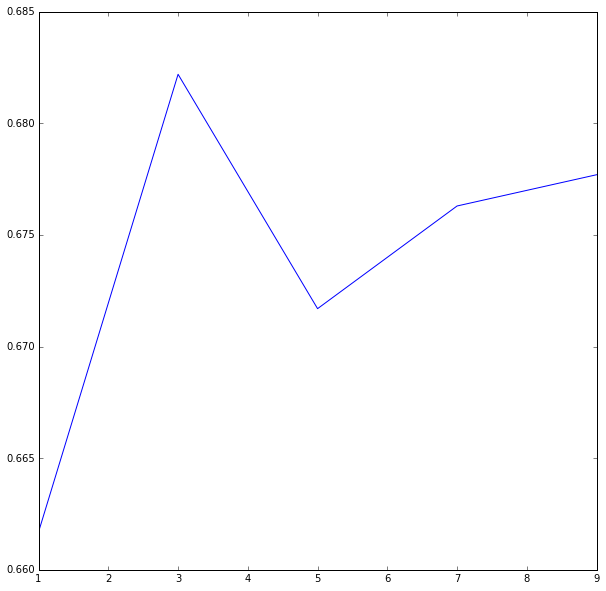

In [103]:
# Now find the best k on the validation set

cifar10_validation_errs = KNN(cifar10_train_X, cifar10_train_Y, cifar10_valid_X, cifar10_valid_Y, [1,3,5,7,9], 1000)
plot(cifar10_validation_errs[0,:], cifar10_validation_errs[1,:])

In [104]:
# Now use the best k to compute the test error

best_K =  1

cifar10_full_train = CIFAR10(("train",), )

cifar10_full_train_X = (cifar10_full_train.data_sources[0].reshape(cifar10_full_train.num_examples, -1) / 255.0).astype(np.single)
cifar10_full_train_Y = cifar10_full_train.data_sources[1].ravel()

cifar10_test_X = (cifar10_test.data_sources[0].reshape(cifar10_test.num_examples, -1) / 255.0).astype(np.single)
cifar10_test_Y = cifar10_test.data_sources[1].ravel()

cifar10_test_errs = KNN(cifar10_full_train_X, cifar10_full_train_Y, cifar10_test_X, cifar10_test_Y, [best_K], 500)
print "\nWhen k=%d the test error rate is %.1f%%" % (cifar10_test_errs[0,0], cifar10_test_errs[1,0]*100.0)


0:500 D S E | 500:1000 D S E | 1000:1500 D S E | 1500:2000 D S E | 2000:2500 D S E | 2500:3000 D S E | 3000:3500 D S E | 3500:4000 D S E | 4000:4500 D S E | 4500:5000 D S E | 5000:5500 D S E | 5500:6000 D S E | 6000:6500 D S E | 6500:7000 D S E | 7000:7500 D S E | 7500:8000 D S E | 8000:8500 D S E | 8500:9000 D S E | 9000:9500 D S E | 9500:10000 D S E | 
When k=1 the test error rate is 64.6%


# Problem 2

In [105]:
rcParams['figure.figsize'] = (10.0, 10.0)
from sklearn import linear_model

In [106]:
mi = lambda x: 1 + 20*x - 1.3*x**2
om = 7

def draw_n(n):
    X = numpy.random.uniform(0. ,10., n)
    X.sort()
    Y = array([numpy.random.normal(mi(x), om) for x in X])
    return X, Y

In [ ]:
X, Y = draw_n(30)

63.8281764044 [ 0.]
34.9128328382 [ 0.          4.82816302]
9.63199542038 [  0.          16.37560055  -1.02126596]
13.6259771052 [  0.          12.61502824  -0.18456388  -0.051608  ]


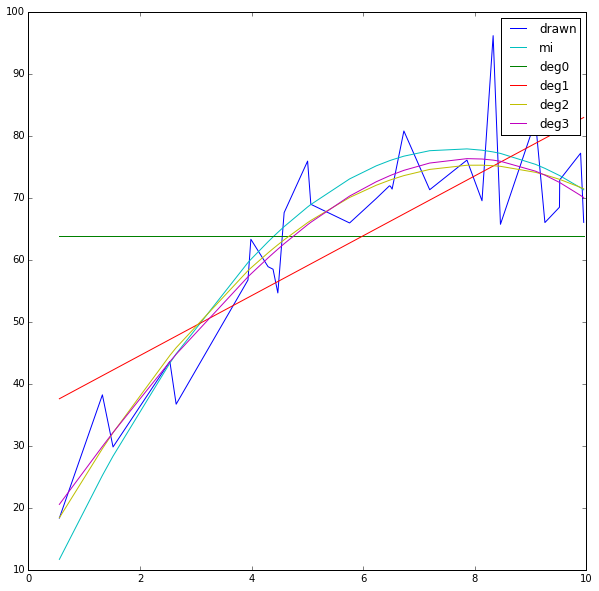

In [109]:
plot(X,Y, label='drawn')
plot(X, [mi(x) for x in X], color='c', label='mi')
def plot_with_x(Xs, color='r', label='xs'):
    clf = linear_model.LinearRegression(fit_intercept=True, normalize=True)
    clf.fit(Xs,Y)
    print clf.intercept_, clf.coef_
    plot(X, clf.predict(Xs), color=color, label=label)

plot_with_x([array([1]) for x in X], color='g', label='deg0')
plot_with_x([array([1, x]) for x in X], label='deg1')
plot_with_x([array([1, x, x**2]) for x in X], color='y', label='deg2')
plot_with_x([array([1, x, x**2, x**3]) for x in X], color='m', label='deg3')
legend()

# Problem 3

In [124]:
from common.gradients import check_gradient,numerical_gradient

In [125]:
# A sample function for debugging purposes

def quadratic(X):
    value = X[0]**2 + 2*X[1]**2
    grad = np.array([2*X[0], 4*X[1]])
    return (value, grad)


# Let's check if the gradientis correctly computed
check_gradient(quadratic, np.array([0,0]))
check_gradient(quadratic, np.array([1.0,1.0]))


True

In [458]:
#
# Fill in the details of the gradient computation
#

def GD(f, Theta0, alpha, stop_tolerance=1e-10, max_steps=1000000):
    history = [Theta0]
    
    Theta = copy(Theta0)
    value = np.inf
    
    step = 0
    while step<max_steps:
        previous_value = value
        value, gradient = f(Theta)
        if value < stop_tolerance:
            break
        
        Theta = Theta - alpha*gradient
        history.append(copy(Theta))
        step += 1
    return Theta, history

In [160]:
#
# Test the GD procedure on the quadratic function
#

Xopt, Xhist = GD(quadratic, np.array((1,1)), 1e-1)
print "Found optimum at %s in %d steps (true minimum is at [0,0])" % (Xopt, len(Xhist))

Found optimum at [  1.14179815e-05   4.84968766e-12] in 52 steps (true minimum is at [0,0])


In [445]:
#
# Now implement the Rosenbrock function 
#

def my_rosenbrock(X):
    A = 1.0
    B = 100.0
    Q1 = (A - X[0])
    Q2 = (X[1] - X[0]**2)
    val = Q1**2 + B * Q2**2
    grad = np.array([2.0 * Q1 * (-1.0) + B * 2.0 * Q2 * (-2.0) * X[0], B * 2.0 * Q2])
    return val, grad

def rosenbrock(X):
    true_val = scipy.optimize.rosen(X)
    true_grad = scipy.optimize.rosen_der(X)
    return true_val, true_grad

#
# And test its gradient
#
check_gradient(my_rosenbrock, np.array([0.,0.]), delta=1e-8)
check_gradient(my_rosenbrock, np.array([1.37324,1.6335]), delta=1e-8)

True

In [459]:
#
# Find the optimum
#

X0= np.array((0.,2.))
Xopt, Xhist = GD(my_rosenbrock, X0, alpha=0.00192, stop_tolerance=1e-10)
Xhist = np.array(Xhist)

print "Found optimum at %s in %d steps (true minimum is at [1,1])" % (Xopt, len(Xhist))

Found optimum at [ 0.99999001  0.99997999] in 13435 steps (true minimum is at [1,1])


(array([[ 0.        ,  2.        ],
        [ 0.00384   ,  1.232     ],
        [ 0.01129853,  0.75891766],
        [ 0.02167937,  0.4675423 ],
        [ 0.03321275,  0.28818653],
        [ 0.04424797,  0.17794649],
        [ 0.05389858,  0.11036687],
        [ 0.06197989,  0.06910153],
        [ 0.0686883 ,  0.04404168],
        [ 0.07433896,  0.02894142]]), array([ 0.99974508,  0.9994892 ]))

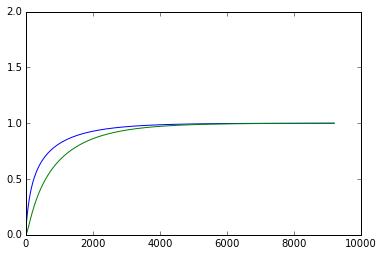

In [308]:
def plot_hist(Xhist):
    steps = arange(0, len(Xhist))
    plot(steps, Xhist[:, 0], label="X[0]")
    plot(steps, Xhist[:, 1], label="X[1]")
    legend()

plot(Xhist)
Xhist[:10], Xhist[-1]

9212

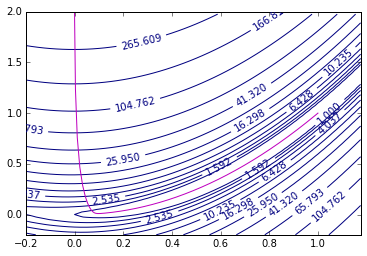

In [455]:
#
# Make a contour plot
#
# you may want to use functions: meshgrid, contour
#
def plot_contour():
    delta = 0.025
    axis = arange(-1.5,3.0, delta)
    axis_x = arange(-0.2, 1.2, delta)
    axis_y = arange(-0.2, 2.0, delta)
    X,Y = np.meshgrid(axis_x, axis_y)
    Zv, Zg = my_rosenbrock((X, Y))
    #contour(X,Y,Z)
    #Zv = sqrt(X**2 + Y**2)
    cs = contour(X, Y, Zv, logspace(0., 20., 100))
    clabel(cs, inline=True)

plot_contour()
plot(Xhist[:,0], Xhist[:, 1], label='gd path', color='m')
len(Xhist)

[array([ 1.00011189,  1.00021373]), array([ 0.9999989,  0.9999978])]

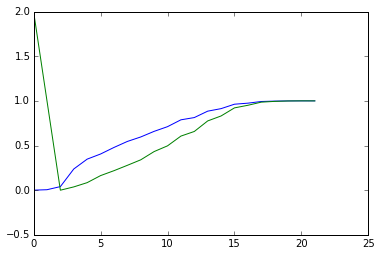

In [460]:
#
# Use scipy.optimize.fmin_l_bfgs_b
# Again plot the path on the coutnour plot
#
# Hint: to save the points you can use the callback argument!
#
import scipy
hist = [X0]
x, f, info = scipy.optimize.fmin_l_bfgs_b(rosenbrock, X0, callback=lambda x: hist.append(copy(x)))
plot(hist)
len(hist)
hist[-2:]

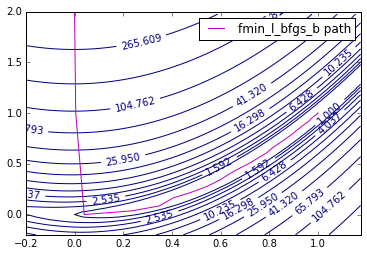

In [450]:
plot_contour()
plot([x[0] for x in hist], [x[1] for x in hist], label='fmin_l_bfgs_b path', color='m')
legend()

# Problem 4

In [98]:
from sklearn import datasets
iris = datasets.load_iris()
print 'Features: ', iris.feature_names
print 'Targets: ', iris.target_names
petal_length = iris.data[:,iris.feature_names.index('petal length (cm)')]
petal_width = iris.data[:, iris.feature_names.index('petal width (cm)')]

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets:  ['setosa' 'versicolor' 'virginica']


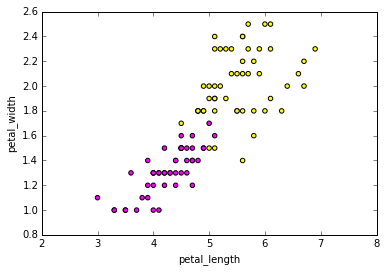

In [415]:
#Extract the petal_length and petal_width of versicolors and virginicas

IrisX = np.vstack([np.ones_like(petal_length), petal_length, petal_width])
IrisX = IrisX[:, iris.target!=0]

# Set versicolor=0 and virginia=1
IrisY = (iris.target[iris.target!=0]-1).reshape(1,-1).astype(np.float64)
def plot_scatter():
    scatter(IrisX[1,:], IrisX[2,:], c=IrisY.ravel(), cmap='spring')
    xlabel('petal_length')
    ylabel('petal_width')
plot_scatter()

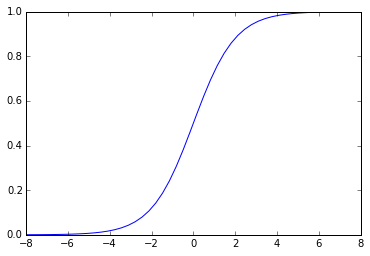

In [320]:
sigmoid = lambda a: 1.0 / (1.0 + exp(-1.0 * a))
Xs = linspace(-8,8)
plot(Xs, sigmoid(Xs))

In [ ]:
sigmoid_diff = lambda a: -1.0 / (1.0 + exp(-1.0 * a)**2)

class LogisticRegressionCost(object):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self._parameters = zip(X,Y)
    
    #note: this creates a Pyton callable - i.e. an abject that can be called as a function
    def __call__(self, Theta):
        X = self.X
        Y = self.Y
        
        #reshape Theta
        ThetaR = Theta.reshape(X.shape[0],1)
        
        # print X.shape, Theta.shape, ThetaR.shape
        #
        # Fill in negative log likelihood computation
        # and gradient computation
        #
        # Properly implemented, this takes about 3 lines of code!
        #
        h = lambda x: sigmoid(ThetaR.T.dot(x))
        Tx = ThetaR.T.dot(X)
        hTx = sigmoid(Tx)
        Tx_diff = Tx/X
        # print Tx, hTx, Tx_diff
        nll = -1.0 * sum([y*log(hTx) + (1.0 - y)*log(1 - hTx) for y in Y])
 
        grad = X.dot((hTx - Y).T)
        
        #reshape gard into the shape of Theta, for fmin_l_bfsgb to work
        return nll, grad.reshape(Theta.shape)

iris_log_reg = LogisticRegressionCost(IrisX, IrisY)

Theta0 = np.zeros((3))
check_gradient(iris_log_reg, Theta0)

#
# Maybe check the gradients at a few other points too?
#


#
# Call a solver
#

ThetaOpt = GD(iris_log_reg, Theta0, alpha=1e-4)[0]

#
# TODO: also tru f_min_lbfsgb??
#

check_gradient(iris_log_reg, ThetaOpt)


#
# Now plot the found separation line 
# 

array([-34.34656973,   4.10858041,   8.69643569])

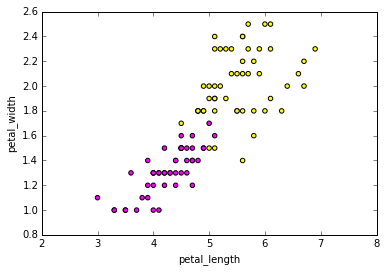

In [473]:
plot_scatter()
ThetaOpt

# Problem 5

In [289]:
a = 5.0
k = 1.0
norm = lambda X: (scipy.special.zeta(a+1, 1) - sum([(1./x**(a+1)) for x in range(1, X)]))
p = lambda N, X: (1./N**(a+1))/norm(X)

In [290]:
p(60, 50), norm(50)

(0.031864711250465222, 6.7263972169939734e-10)

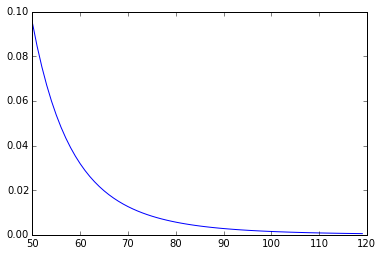

In [291]:
Xs = arange(50, 120)
plot(Xs, [p(x, 50) for x in Xs])

In [268]:
scipy.special.zeta(3,1)

1.202056903159594